# Shack-Hartmann Wavefront Sensor

In [1]:
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


A $N_L\times N_L$ Shack-Hartmann wavefront sensor (WFS) on a $D$ diameter telescope is going to be modeled with $n_P\times n_P$ pixels per lenslet on the detector.

In [2]:
nLenslet = 60
D = 25.5
n = 6
nPx = n*nLenslet+1

A arbitrary number of guide stars (GS) can be used by one WFS model, the assumption beeing that all the GS uses exactly the same WFS.
Here the GS are randomly distributed in a 10arcmin diameter field of regard.

In [3]:
nGS = 1
zen = np.random.uniform(-1,1,nGS)*5*math.pi/180/60
azi = np.random.uniform(0,2*math.pi,nGS)
gs = ceo.Source("K",zenith=zen,azimuth=azi,height=float("inf"),resolution=(nPx,nPx))

Next the telescope pupil mask is defined and applied to the GSs.

In [4]:
tel = ceo.GMT(nPx,D)
#tel = ceo.Telescope(nPx)
#tel = ceo.Mask(nPx)
gs.masked(tel)

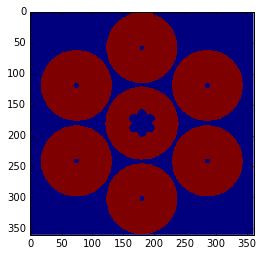

In [5]:
imshow(tel.f.host(shape=(nPx,nPx)),interpolation='none')

The shack-Hartmann WFS is defined with the `shackHartmann` class.
The mandatory parameters of the class constructor are:
 - the lenslet array size $N_L$,
 - the number of pixel per lenslet in the pupil plane $n_P$ with pixels on the lenslet edges, meaning that the wavefront of the corresponding GSs must be sampled with $(N_L n_P+1) \times (N_L n_P+1)$ pixels,
 - the lenslet pitch $d$.
 
 By default, the WFS imagelets are Nyquist sampled meaning that the default value of the discrete Fourier transform over-sampling factor is set to 2, i.e. $\alpha\equiv$ `DFT_osf=2`.
 The size of each imagelet is then  $\alpha n_P \times \alpha n_P$.
 
 The detector framelet sizes are `N_PX_IMAGE`$\times $ `N_PX_IMAGE` pixels each with the default value `N_PX_IMAGE` $=n_P$.
 If the imagelets are larger, they are cropped to the specified size, if they are smaller, the framelets are padded with zeros.
 
 Finally the framelets can be binned down by a factor $\beta\equiv$ `BIN_IMAGE` leading to a final framelet size of $${N_I\over\beta}\times{N_I\over\beta}$$ with $N_I\equiv$ `N_PX_IMAGE`.
 The default value of `BIN_IMAGE` is 1.
 
 The pixel scale is given by: 
 $${\beta\lambda \over \alpha d}$$ 
 and the lenslet field-of-view is 
 $$N_I{\lambda\over \alpha d}$$ 
 with $\lambda$ the wavelength.
 
 If more than on GS is assigned to the WFS, the parameter `N_GS` needs to be set.

In [6]:
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=n,N_GS = nGS)

The WFS reference slopes and valid lenslets are set with the `calibrate` method passing a `Source` object which wavefront sets the reference slopes and the lenslet intensity threshold used to discard the lenset with too litle illumination.

In [7]:
wfs.calibrate(gs,0.5)

The source wavefront can now be analyzed with respect to the former calibration.

In [8]:
wfs.analyze(gs)

The detector frame is saved in the `cuFloatArray` object `frame`.

In [9]:
wfs.frame.host().shape

(360, 360)

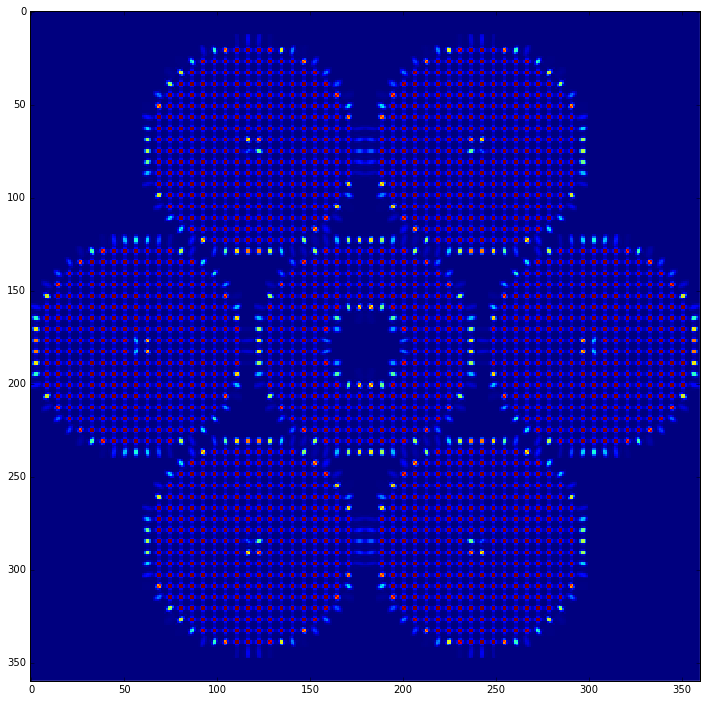

In [10]:
figure(figsize=(12,12))
imshow(wfs.frame.host().transpose(),interpolation='none')

In [11]:
print wfs.frame.host()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


A `Atmosphere` object is defined next and the GSs are propagated through:

In [12]:
atm =ceo.GmtAtmosphere(15e-2,30)
p = D/nPx
atm.get_phase_screen(gs,  p, nPx, p, nPx, 0.0)

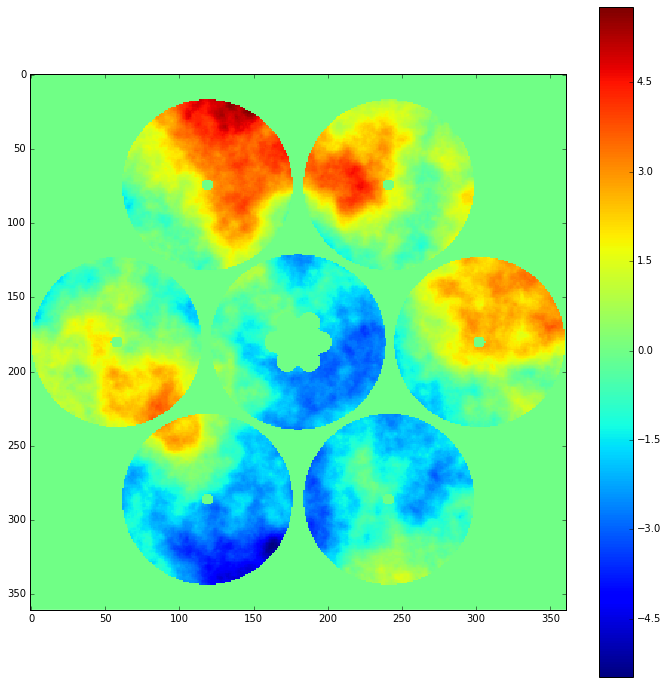

In [13]:
figure(figsize=(12,12))
imshow(gs.phase.host(units='micron').transpose(),interpolation='none')
colorbar()

The WFS detector need to be reset before proceeding with a new wavefront analysis.

In [14]:
wfs.reset()
wfs.analyze(gs)

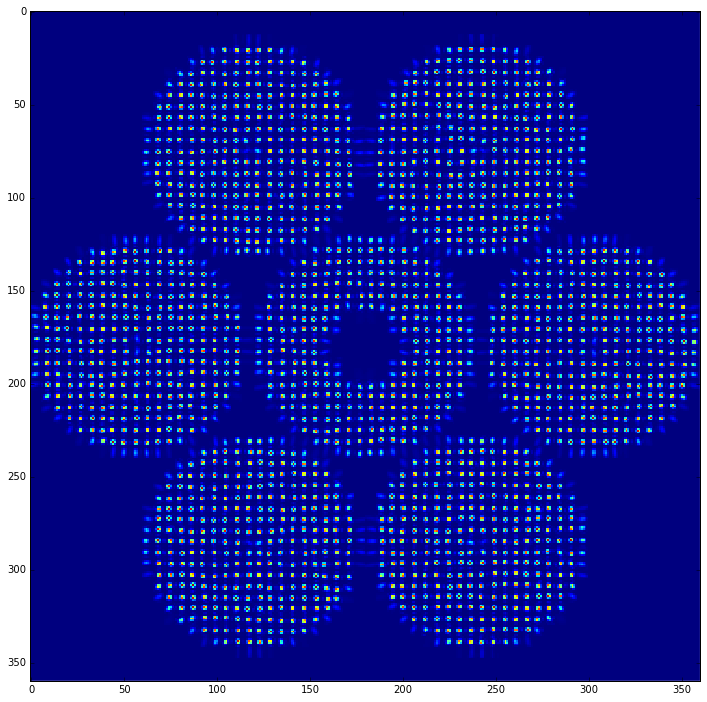

In [15]:
figure(figsize=(12,12))
imshow(wfs.frame.host().transpose(),interpolation='none')

The WFS centroids are accessible through the `cuFloatArray` object `c`.

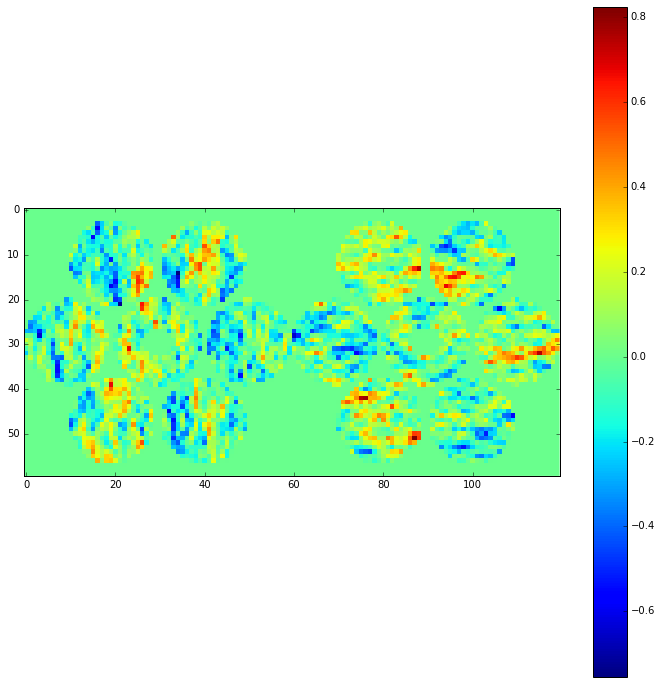

In [16]:
figure(figsize=(12,12))
imshow(wfs.c.host(units='arcsec').reshape(2*nLenslet*nGS
                            ,nLenslet).transpose(),interpolation='none')
colorbar()